# [Virtual Epileptic Patient](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/vep_sde_numba.ipynb)

<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/vep_sde_numba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install VBI package in Google Colab (lightweight, CPU-only version)
print("Setting up VBI for Google Colab...")

# Skip C++ compilation for faster installation in Colab
%env SKIP_CPP=1

# Install the package
!pip install vbi

print("VBI package installed successfully! Ready to proceed.")

In [1]:
import os
import tqdm
import pickle
import numpy as np
import networkx as nx
from vbi import report_cfg
import autograd.numpy as anp
import matplotlib.pyplot as plt
from vbi.utils import LoadSample
from vbi.plot import pairplot_numpy
from vbi.models.numba.vep import VEP_sde
from vbi.cde import MAFEstimator, MDNEstimator
from sklearn.preprocessing import StandardScaler
from vbi.utils import posterior_shrinkage_numpy, posterior_zscore_numpy, posterior_peaks_numpy

In [29]:
seed = 2
np.random.seed(seed)

In [30]:
path = "output/vep_sde_numba_cde_"
os.makedirs(path, exist_ok=True)

In [31]:
weights = np.loadtxt("data/weights1.txt")
nn = weights.shape[0]

healthy zone, propagation zone, epileptic zone eta values

In [32]:
hz_val = -3.65
pz_val = -2.4
ez_val = -1.6

In [33]:
ez_idx = np.array([6, 34], dtype=np.int32)
pz_wplng_idx = np.array([5, 11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [34]:
eta_true = np.ones(nn) * hz_val
eta_true[pz_idx] = pz_val
eta_true[ez_idx] = ez_val

In [35]:
initial_state = np.zeros(2 * nn)
initial_state[:nn] = -2.5
initial_state[nn:] = 3.5
# --------------------------------------------------------------------------- #

In [36]:
params = {
    "G": 1.0,
    "initial_state": initial_state,
    "weights": weights,
    "tau": 10.0,
    "eta": -3.5,
    "sigma": 0.0,
    "iext": 3.1,
    "dt": 0.1,
    "t_end": 14.0,
    "t_cut": 1.0,
    "record_step": 1,
    "method": "heun",
    "output": path,
}

In [37]:
obj = VEP_sde(params)
g_true = 1.0
eta_true = [-1.6] * 2
eta_true_ = np.ones(nn) * hz_val
eta_true_[pz_idx] = pz_val
eta_true_[ez_idx] = ez_val
control_true = {"eta": eta_true_, "G": g_true}

In [38]:
data = obj.run(par=control_true)

In [39]:
print(obj.P.eta[:5])
print(obj.P.iext[:5])

[-3.65 -3.65 -3.65 -3.65 -3.65]
[3.1 3.1 3.1 3.1 3.1]


In [40]:
ts = data["x"]
t = data["t"]

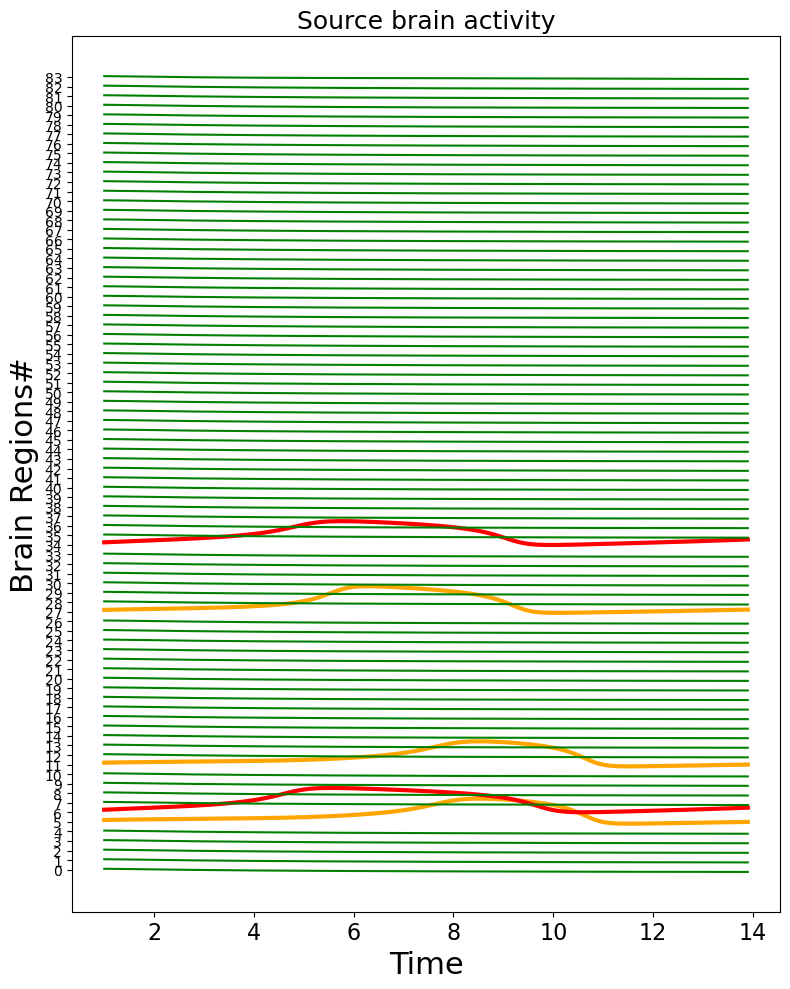

In [41]:

plt.figure(figsize=(8, 10))
for i in range(0, nn):
    if i in ez_idx:
        plt.plot(t, ts[i, :] + i, "r", lw=3)
    elif i in pz_idx:
        plt.plot(t, ts[i, :] + i, "orange", lw=3)
    else:
        plt.plot(t, ts[i, :] + i, "g")
plt.yticks(np.r_[0:nn] - 2, np.r_[0:nn], fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity", fontsize=18)
plt.xlabel("Time", fontsize=22)
plt.ylabel("Brain Regions#", fontsize=22)
plt.tight_layout()
# plt.savefig("output/vep_sde.png", dpi=300)

In [42]:
from vbi.feature_extraction.features_settings import *
from vbi.feature_extraction.calc_features import *

In [43]:
fs = 1 / (params["dt"]) / 1000
cfg = get_features_by_domain(domain="statistical")
# cfg = get_features_by_given_names(cfg, names=["calc_moments"])
cfg = get_features_by_given_names(cfg, names=["auc"])
# report_cfg(cfg)

In [44]:
data = extract_features_df([ts], fs, cfg=cfg, n_workers=1)
print(data.values.shape)

100%|██████████| 1/1 [00:00<00:00, 937.90it/s]

(1, 84)


In [45]:
def wrapper(params, control, x0, cfg, verbose=False):
    vep_obj = VEP_sde(params)
    sol = vep_obj.run(control, x0=x0)

    # extract features
    fs = 1.0 / params["dt"] * 1000  # [Hz]
    stat_vec = extract_features(
        ts=[sol["x"]], cfg=cfg, fs=fs, n_workers=1, verbose=verbose
    ).values[0]
    return stat_vec

In [46]:
def batch_run(params, control_list, x0, cfg, n_workers=1):
    n = len(control_list)
    def update_bar(_):
        pbar.update()
    with Pool(processes=n_workers) as pool:
        with tqdm.tqdm(total=n) as pbar:
            async_results = [
                pool.apply_async(
                    wrapper,
                    args=(params, control_list[i], x0, cfg, False),
                    callback=update_bar,
                )
                for i in range(n)
            ]
            stat_vec = [res.get() for res in async_results]
    return stat_vec

In [47]:
num_sim = 1000
num_workers = 10
eta_min, eta_max = -5.0, -1.0
gmin, gmax = 0.0, 2.0

In [48]:
from vbi.utils import BoxUniform
prior_min = [gmin] + [eta_min] * 2
prior_max = [gmax] + [eta_max] * 2
prior = BoxUniform(low=prior_min, high=prior_max)
theta = prior.sample((num_sim))

In [49]:
control_list = []
for i in range(num_sim):
    eta_ = np.ones(nn) * hz_val
    eta_[pz_idx] = pz_val
    eta_[ez_idx] = theta[i, 1:]
    g_ = theta[i, 0]
    control_list.append({"eta": eta_, "G": g_})

In [50]:
stat_vec = batch_run(params, control_list, initial_state, cfg, num_workers)

100%|██████████| 1000/1000 [00:00<00:00, 1154.90it/s]


In [51]:
scalar = StandardScaler()
stat_vec = scalar.fit_transform(np.array(stat_vec))

In [52]:
xo = wrapper(params, control_true, initial_state, cfg)
xo = scalar.transform(xo.reshape(1, -1))

print(theta.shape, stat_vec.shape, xo.shape)

(1000, 3) (1000, 84) (1, 84)


In [53]:
rng = anp.random.RandomState(seed)
maf_estimator = MAFEstimator(n_flows=8, hidden_units=128)
maf_estimator.train(theta, stat_vec, n_iter=500, learning_rate=2e-4)
print("best epoch:", maf_estimator.best_epoch, "best val:", maf_estimator.best_val_loss)
samples = maf_estimator.sample(xo, n_samples=5000, rng=rng)[0]

Inferred dimensions: param_dim=3, feature_dim=84


Training: 100%|██████████| 500/500 [00:42<00:00, 11.85it/s, patience=18/20, train=-4.7174, val=-4.7893]


best epoch: 481 best val: -5.0133819580078125


In [54]:
with open(path + "/posterior.pkl", "wb") as f:
    pickle.dump(maf_estimator, f)

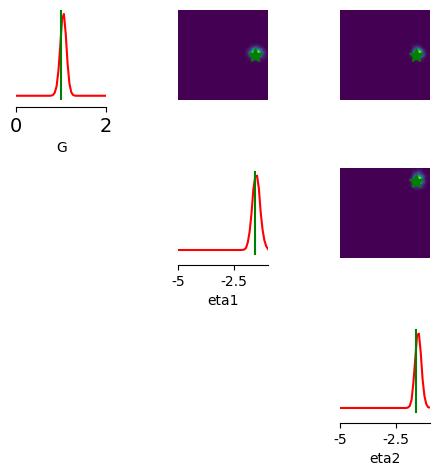

In [55]:
limits = [[i, j] for i, j in zip(prior_min, prior_max)]
points = [[g_true] + eta_true]
fig, ax = pairplot_numpy(
    samples,
    limits=limits,
    figsize=(5, 5),
    points=np.array(points).reshape(1, -1),
    labels=["G", "eta1", "eta2"],
    diag="kde",
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["g"]),
    diag_kwargs={"mpl_kwargs": {"color": "r"}},
)
ax[0, 0].tick_params(labelsize=14)
ax[0, 0].margins(y=0)
plt.tight_layout();